In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch
import numpy as np
from tqdm import tqdm
import pickle as pkl
import pandas as pd
from util.dataset import *

In [2]:
train_dataset = UPBDataset("../dataset", train=True, augm=True)

In [3]:
def compute_weights(nclasses=8):
    global train_dataset
    
    counts = [0] * nclasses
    rel_course = [0] * len(train_dataset)
    
    for i in tqdm(range(len(train_dataset))):
        rel_course[i] = int(np.clip(np.abs(train_dataset[i]['rel_course_val'].item()), 0, nclasses - 1))
        counts[rel_course[i]] += 1
        
    weights_per_class = [0.] * nclasses
    N = np.sum(counts)
    for i in range(nclasses):
        weights_per_class[i] = N / float(nclasses * counts[i])
    
    weights = [0] * len(train_dataset)
    for i in tqdm(range(len(rel_course))):
        weights[i] = weights_per_class[rel_course[i]]
    return weights

In [4]:
nclasses = 6
weights = compute_weights(nclasses=nclasses)

100%|██████████| 73894/73894 [00:00<00:00, 3066072.12it/s]


In [5]:
tf_weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(tf_weights, len(tf_weights))
train_loader = DataLoader(
    train_dataset, 
    batch_size=1024, 
    sampler = sampler, 
    num_workers=4, 
    pin_memory=True
)

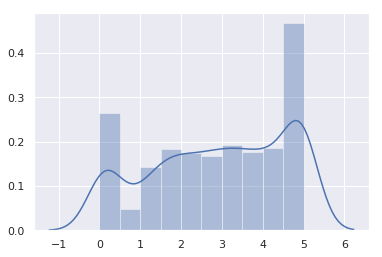

In [6]:
for i, data in enumerate(train_loader):
    rel_course = data['rel_course_val'].numpy().reshape(-1)
    rel_course = np.clip(np.abs(rel_course), 0, nclasses-1)
    plt.figure()
    sns.distplot(rel_course)
    plt.show()
    break

In [7]:
df = pd.DataFrame(data=weights, columns=["name"])
df.to_csv("../dataset/weights_train_aug.csv", index=False)

In [8]:
df_weights = pd.read_csv("../dataset/weights_train_aug.csv")
df_weights.head()

,name
0,1.385651
1,0.407008
2,0.407008
3,0.407008
4,0.407008
